In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pickle as pkl

%matplotlib inline

In [3]:
import torch
from torchvision import datasets
from torchvision import transforms

transform = transforms.ToTensor()

svhn_data = datasets.SVHN('root/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0 

svhn_loader = torch.utils.data.DataLoader(svhn_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Using downloaded and verified file: root/train_32x32.mat


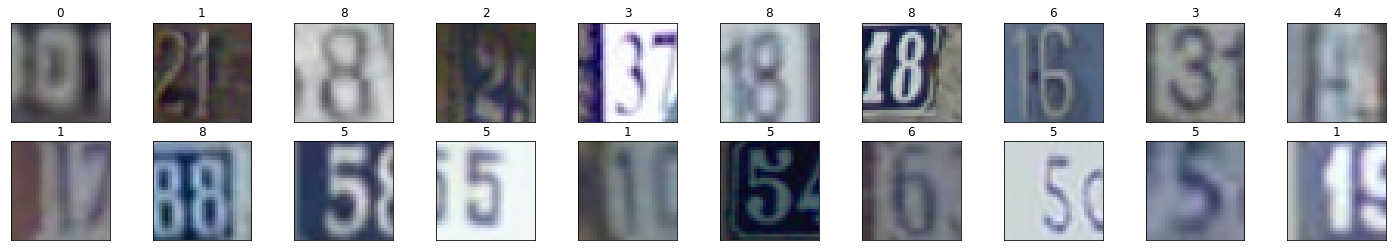

In [4]:
dataiter =  iter(svhn_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx],(1,2,0)))
    ax.set_title(str(labels[idx].item()))

In [5]:
img = images[126]

print(img.min())
print(img.max())

tensor(1.00000e-02 *
       8.2353)
tensor(0.7098)


In [6]:
def scale(x, feature_range=(-1, 1)):
    
    x = x * 2 - 1
    
    return x

In [7]:
img = scale(images[5])

print(img.min())
print(img.max())

tensor(-0.4039)
tensor(0.7333)


In [8]:
# define the common function conv which build convolution followed by optional batch norm layer.
import torch.nn as nn 
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)


In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 16X16X32
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # 8X8X64
        self.conv3 = conv(conv_dim*2, conv_dim*2*2, 4) # 4X4X128
        self.fc = nn.Linear(conv_dim*2*2*4*4, 1) # 2048 -> 1 
        
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*2*2*4*4)
        x = self.fc(x)
        
        return x
        
        

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)
    

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
            
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4) # 4X4X128
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4) # 8X8X64
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4) # 16X16X32
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False) # 32X32X3
            
    def forward(self, x):
        
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        x = F.tanh(self.t_conv3(x))
        
        return x
        
        

In [14]:
conv_dim = 32 
z_size=100

D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [15]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    D = D.cuda()
    G = G.cuda()
    print('cuda is available. Model moved to GPU')
else:
    print('Training on CPU')
    

Training on CPU


In [1]:
def d_real_loss(D_out, smooth=False):
    
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def d_fake_loss(D_out):
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss
    

In [2]:
import torch.optim as optim 

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(). lr, [beta1, beta2])


NameError: name 'D' is not defined

In [ ]:
import pickle as pkl 

num_epochs = 30
sample_size = 16 

samples = []
losses = []

fixed_z = np.random.uniform(-1,1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

for ep in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(svhn_loader):
        
        batch_size = real_images.size(0)
        
        real_images = scale(real_images)
        
        # Train the discriminator
        # calculate real loss 
        real_out = D(real_images)
        d_loss_real = d_real_loss(real_out, True)
        
        #calculate fale loss
        # generate fake images 
        z = np.random.uniform(-1,1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        fake_images = G(z)
        fake_out = D(fake_images)
        d_loss_fake = d_fake_loss(fake_out)
        
        # total discriminator loss
        d_loss_total = d_loss_real + d_loss_fake
        
        #backprop
        d_loss_total.backward()
        d_optimizer.step()
        
        # Train the generator 
        # calculate g_loss 
        z = np.random.uniform(-1,1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        fake_images = G(z)
        g_loss = d_real_loss(D(fake_images), True)
        
        g_loss.backward()
        g_optimizer.step()
        
        if batch_i % print_every == 0:
            losses.append((d_loss_total.item(), g_loss.item()))
            print("Epoch {:5d}/{:5d} | d_loss {:6.4f} | g_loss{:6.4f}".format(ep, num_epochs, d_loss_total.item(), g_loss.item()))
        